<a href="https://colab.research.google.com/github/Radperia/SIGNATE_student_2020/blob/master/SIGNATE_Tfidf_LogisticRegreession.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack

In [3]:
class_names = ['DataScientist', 'MachineLearningEngineer', 'SoftwareEngineer', 'Consultant']

train = pd.read_csv('./drive/My Drive/SIGNATE/train.csv').fillna(' ')
test = pd.read_csv('./drive/My Drive/SIGNATE/test.csv').fillna(' ')

train_text = train['description']
test_text = test['description']
all_text = pd.concat([train_text, test_text])

In [23]:
train['DataScientist'] = 0
train['MachineLearningEngineer'] = 0
train['SoftwareEngineer'] = 0
train['Consultant'] = 0

print(train['jobflag'][2])

4


In [25]:
# カッコいい書き方が分からない

for i in range(train.shape[0]):

    if(train['jobflag'][i]==1):
        train['DataScientist'][i]=1

    elif(train['jobflag'][i]==2):
        train['MachineLearningEngineer'][i]=1

    elif(train['jobflag'][i]==3):
        train['SoftwareEngineer'][i]=1
        
    elif(train['jobflag'][i]==4):
        train['Consultant'][i]=1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: Set

In [26]:
train.head()

,id,description,jobflag,DataScientist,MachineLearningEngineer,SoftwareEngineer,Consultant
0,0,"Executes and writes portions of testing plans,...",2,0,1,0,0
1,1,Maintain Network Performance by assisting with...,3,0,0,1,0
2,2,Supports the regional compliance manager with ...,4,0,0,0,1
3,3,Keep up to date with local and national busine...,1,1,0,0,0
4,4,Assist with Service Organization Control (SOC)...,4,0,0,0,1


In [73]:
from wordcloud import STOPWORDS
from collections import defaultdict

def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

In [76]:
DS = train['jobflag'] == 1
MLE = train['jobflag'] == 2 
SE = train['jobflag'] == 3
C = train['jobflag'] == 4

In [78]:
DS_bigrams = defaultdict(int)
MLE_bigrams = defaultdict(int)
SE_bigrams = defaultdict(int)
C_bigrams = defaultdict(int)

for desc in train[DS]['description']:
    for word in generate_ngrams(desc, n_gram=2):
        DS_bigrams[word] += 1

for desc in train[MLE]['description']:
    for word in generate_ngrams(desc, n_gram=2):
        MLE_bigrams[word] += 1

for desc in train[SE]['description']:
    for word in generate_ngrams(desc, n_gram=2):
        SE_bigrams[word] += 1

for desc in train[C]['description']:
    for word in generate_ngrams(desc, n_gram=2):
        C_bigrams[word] += 1

df_DS_bigrams = pd.DataFrame(sorted(DS_bigrams.items(), key=lambda x: x[1])[::-1])
df_MLE_bigrams = pd.DataFrame(sorted(MLE_bigrams.items(), key=lambda x: x[1])[::-1])
df_SE_bigrams = pd.DataFrame(sorted(SE_bigrams.items(), key=lambda x: x[1])[::-1])
df_C_bigrams = pd.DataFrame(sorted(C_bigrams.items(), key=lambda x: x[1])[::-1])

In [82]:
df_MLE_bigrams

,0,1
0,machine learning,52
1,data science,10
2,data scientists,9
3,learning models,8
4,work closely,8
...,...,...
2726,"plans, protocols,",1
2727,"testing plans,",1
2728,portions testing,1
2729,writes portions,1


In [79]:
DS_trigrams = defaultdict(int)
MLE_trigrams = defaultdict(int)
SE_trigrams = defaultdict(int)
C_trigrams = defaultdict(int)

for desc in train[DS]['description']:
    for word in generate_ngrams(desc, n_gram=3):
        DS_trigrams[word] += 1

for desc in train[MLE]['description']:
    for word in generate_ngrams(desc, n_gram=3):
        MLE_trigrams[word] += 1

for desc in train[SE]['description']:
    for word in generate_ngrams(desc, n_gram=3):
        SE_trigrams[word] += 1

for desc in train[C]['description']:
    for word in generate_ngrams(desc, n_gram=3):
        C_trigrams[word] += 1

df_DS_trigrams = pd.DataFrame(sorted(DS_trigrams.items(), key=lambda x: x[1])[::-1])
df_MLE_trigrams = pd.DataFrame(sorted(MLE_trigrams.items(), key=lambda x: x[1])[::-1])
df_SE_trigrams = pd.DataFrame(sorted(SE_trigrams.items(), key=lambda x: x[1])[::-1])
df_C_trigrams = pd.DataFrame(sorted(C_trigrams.items(), key=lambda x: x[1])[::-1])

In [83]:
df_MLE_trigrams

,0,1
0,machine learning models,8
1,work closely data,4
2,machine learning applications,4
3,develop machine learning,3
4,machine learning algorithms,3
...,...,...
2636,"plans, protocols, documentation",1
2637,"testing plans, protocols,",1
2638,"portions testing plans,",1
2639,writes portions testing,1


In [4]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)
word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

In [5]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=50000)
char_vectorizer.fit(all_text)
train_char_features = char_vectorizer.transform(train_text)
test_char_features = char_vectorizer.transform(test_text)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:520: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'stop_words' will not be used"


In [85]:
bigram_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(2,2),
    max_features=20000)
bigram_vectorizer.fit(all_text)
train_bigram_features = bigram_vectorizer.transform(train_text)
test_bigram_features = bigram_vectorizer.transform(test_text)

In [86]:
trigram_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(3,3),
    max_features=20000)
trigram_vectorizer.fit(all_text)
train_trigram_features = trigram_vectorizer.transform(train_text)
test_trigram_features = trigram_vectorizer.transform(test_text)

In [87]:
train_features = hstack([train_char_features, train_word_features, train_bigram_features, train_trigram_features])
test_features = hstack([test_char_features, test_word_features, test_bigram_features, test_trigram_features])

In [88]:
scores = []
submission = pd.DataFrame.from_dict({'id': test['id']})

for class_name in class_names:
    train_target = train[class_name]
    classifier = LogisticRegression(C = 0.01, solver = 'sag', class_weight='balanced')

    cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring = 'f1_macro'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_features, train_target)
    submission[class_name] = classifier.predict_proba(test_features)[:, 1]

print('Total CV score is {}',format(np.mean(scores)))

CV score for class DataScientist is 0.7666148794992873
CV score for class MachineLearningEngineer is 0.6838723142222508
CV score for class SoftwareEngineer is 0.752189504262768
CV score for class Consultant is 0.70782007196956
Total CV score is {} 0.7276241924884665


In [89]:
submission

,id,DataScientist,MachineLearningEngineer,SoftwareEngineer,Consultant
0,2931,0.478353,0.480695,0.494427,0.504407
1,2932,0.465045,0.474013,0.513482,0.492999
2,2933,0.477363,0.480663,0.504661,0.489919
3,2934,0.548762,0.484074,0.454181,0.488724
4,2935,0.468126,0.455525,0.504594,0.516162
...,...,...,...,...,...
1738,4669,0.549844,0.464813,0.458268,0.493356
1739,4670,0.471038,0.469630,0.505404,0.502284
1740,4671,0.495077,0.480343,0.491056,0.492720
1741,4672,0.481673,0.462393,0.498150,0.506908


In [90]:
submission['flag'] = 0

for i in range(submission.shape[0]):
    submission['flag'][i] = np.stack([submission['DataScientist'][i], submission['MachineLearningEngineer'][i], submission['SoftwareEngineer'][i], submission['Consultant'][i]]).argmax() + 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [91]:
submission

,id,DataScientist,MachineLearningEngineer,SoftwareEngineer,Consultant,flag
0,2931,0.478353,0.480695,0.494427,0.504407,4
1,2932,0.465045,0.474013,0.513482,0.492999,3
2,2933,0.477363,0.480663,0.504661,0.489919,3
3,2934,0.548762,0.484074,0.454181,0.488724,1
4,2935,0.468126,0.455525,0.504594,0.516162,4
...,...,...,...,...,...,...
1738,4669,0.549844,0.464813,0.458268,0.493356,1
1739,4670,0.471038,0.469630,0.505404,0.502284,3
1740,4671,0.495077,0.480343,0.491056,0.492720,1
1741,4672,0.481673,0.462393,0.498150,0.506908,4


Text(0, 0.5, 'samples')

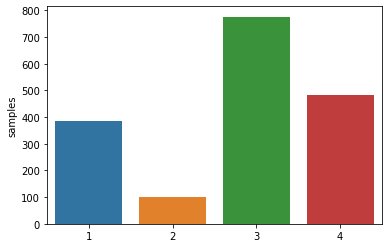

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

jobflag_vals = submission.flag.value_counts()
sns.barplot(jobflag_vals.index, jobflag_vals)
plt.gca().set_ylabel('samples')

In [93]:
submission.to_csv('bi-tri_balanced_LR.csv', index=False)

from google.colab import files
files.download('bi-tri_balanced_LR.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

non bi-tri feature: 0.4462  
bi-tri added feature: 0.427